# Clustering

Clustering is a fundamental technique in machine learning that involves grouping similar data points or objects together based on their inherent characteristics or similarities. 
The main objective of clustering is to partition a dataset into distinct clusters, where data points within each cluster are more similar to each other than to those in other clusters.

## Applying Cluster Models

Cluster models in machine learning are algorithms that group similar data points together based on certain similarities or patterns in the data. The primary objective of clustering is to identify distinct clusters or subgroups within a dataset, where data points within each cluster are more similar to each other than to those in other clusters.

In this lab, you will use K-means and agglomerative clustering techniques to discover patterns in the automotive dataset. Finding meaningful clusters in such a intricate dataset presents a considerable challenge. The difficulty lies in two aspects: firstly, determining the optimal number of clusters, and secondly, interpreting these clusters in a meaningful and practical way. Such challenges are common in unsupervised learning scenarios.

## Preparing Dataset

Preparation of the dataset is necessary before building and evaluating cluster models. The first step for preparing the dataset is to load the required packages. Run the code to load the required libraries.

In [19]:
library(ggplot2)
library(gridExtra)
library(MASS)
library(gridExtra)
library(cluster)
library(caret)
library(repr)
library(dplyr)

Run the code in the cell below to load the autos dataset from given csv file. [Download CSV File] 

In [8]:
auto_prices = read.csv('Auto_Prices_Preped.csv')
auto_prices = auto_prices[,c('make', 'fuel.type', 'aspiration', 'num.of.doors', 'body.style', 
                             'drive.wheels', 'wheel.base', 'length', 'width', 'height',
                             'curb.weight', 'num.of.cylinders', 'engine.size', 'bore', 
                             'stroke', 'compression.ratio', 'horsepower', 'peak.rpm', 
                             'city.mpg', 'highway.mpg', 'log_price')]
names(auto_prices)
dim(auto_prices)

[1] "make"              "fuel.type"         "aspiration"       
 [4] "num.of.doors"      "body.style"        "drive.wheels"     
 [7] "wheel.base"        "length"            "width"            
[10] "height"            "curb.weight"       "num.of.cylinders" 
[13] "engine.size"       "bore"              "stroke"           
[16] "compression.ratio" "horsepower"        "peak.rpm"         
[19] "city.mpg"          "highway.mpg"       "log_price"

[1] 195  21

You can observe that the dataset contains 21 columns (dimensions) but only a small number of cases, totaling 195. The small number of rows in comparison to the number of features adds to the challenge of this problem.

Now, run the below given code to encode the categorical variables as dummy variables.

In [9]:
dummies = dummyVars(highway.mpg ~ ., data = auto_prices)
auto_dummies = data.frame(predict(dummies, newdata = auto_prices))
names(auto_dummies)

[1] "makealfa.romero"              "makeaudi"                    
 [3] "makebmw"                      "makechevrolet"               
 [5] "makedodge"                    "makehonda"                   
 [7] "makeisuzu"                    "makejaguar"                  
 [9] "makemazda"                    "makemercedes.benz"           
[11] "makemercury"                  "makemitsubishi"              
[13] "makenissan"                   "makepeugot"                  
[15] "makeplymouth"                 "makeporsche"                 
[17] "makesaab"                     "makesubaru"                  
[19] "maketoyota"                   "makevolkswagen"              
[21] "makevolvo"                    "fuel.typediesel"             
[23] "fuel.typegas"                 "aspirationstd"               
[25] "aspirationturbo"              "num.of.doors."               
[27] "num.of.doorsfour"             "num.of.doorstwo"             
[29] "body.stylehardtop_convert"    "body.stylehatchback"         
[31] "body.stylesedan"              "body.stylewagon"             
[33] "drive.wheels4wd"              "drive.wheelsfwd"             
[35] "drive.wheelsrwd"              "wheel.base"                  
[37] "length"                       "width"                       
[39] "height"                       "curb.weight"                 
[41] "num.of.cylinderseight_twelve" "num.of.cylindersfive_six"    
[43] "num.of.cylindersthree_four"   "engine.size"                 
[45] "bore"                         "stroke"                      
[47] "compression.ratio"            "horsepower"                  
[49] "peak.rpm"                     "city.mpg"                    
[51] "log_price"

Now, run the below given code to logarithmically transform certain numeric columns.

In [10]:
num_cols = c('wheel.base', 'curb.weight', 'engine.size', 'bore', 'stroke', 'horsepower', 
             'city.mpg', 'log_price')
auto_dummies[,num_cols] = lapply(auto_dummies[,num_cols], log)

Now, run the below given code to normalize the numeric variables using the *preProcess* function from the Caret package.

In [11]:
num_cols <- c('wheel.base', 'length', 'width', 'height', 'curb.weight', 'engine.size',
              'bore', 'stroke', 'compression.ratio', 'horsepower', 'peak.rpm', 'city.mpg',
              'log_price')

preProcValues <- preProcess(auto_dummies[, num_cols], method = c("center", "scale"))

auto_dummies[, num_cols] <- predict(preProcValues, auto_dummies[, num_cols])

Now, run the below given code to near zero variance variables using the nearZeroVar function.

In [12]:
near_zero = nearZeroVar(auto_dummies, freqCut = 95/5, uniqueCut = 10, saveMetrics = TRUE)
near_zero[near_zero$zeroVar == TRUE | near_zero$nzv == TRUE, ]

,freqRatio,percentUnique,zeroVar,nzv
,<dbl>,<dbl>,<lgl>,<lgl>
makealfa.romero,64.00000,1.025641,FALSE,TRUE
makeaudi,31.50000,1.025641,FALSE,TRUE
makebmw,23.37500,1.025641,FALSE,TRUE
makechevrolet,64.00000,1.025641,FALSE,TRUE
makedodge,20.66667,1.025641,FALSE,TRUE
makeisuzu,96.50000,1.025641,FALSE,TRUE
makejaguar,64.00000,1.025641,FALSE,TRUE
makemercedes.benz,23.37500,1.025641,FALSE,TRUE
makemercury,194.00000,1.025641,FALSE,TRUE


The code in the below cell will remove columns with near zero variance. The *select* verb from the R dplyr package is used along with *starts_with* function. Run this code.

In [13]:
auto_dummies <- auto_dummies %>%
  select(-starts_with("make"), -starts_with("num.of.doors"),
         -contains("drive.wheels.4wd"), -contains("num.of.cylinders.eight_twelve"))

names(auto_dummies)

[1] "fuel.typediesel"              "fuel.typegas"                
 [3] "aspirationstd"                "aspirationturbo"             
 [5] "body.stylehardtop_convert"    "body.stylehatchback"         
 [7] "body.stylesedan"              "body.stylewagon"             
 [9] "drive.wheels4wd"              "drive.wheelsfwd"             
[11] "drive.wheelsrwd"              "wheel.base"                  
[13] "length"                       "width"                       
[15] "height"                       "curb.weight"                 
[17] "num.of.cylinderseight_twelve" "num.of.cylindersfive_six"    
[19] "num.of.cylindersthree_four"   "engine.size"                 
[21] "bore"                         "stroke"                      
[23] "compression.ratio"            "horsepower"                  
[25] "peak.rpm"                     "city.mpg"                    
[27] "log_price"

## Applying K-means Clustering

As the data is prepared, you will now create and discover a series of K-means clustering models applied to the data set. The code given in the cell below will compute a k=2 k-means cluster model. Run this code.

In [14]:
set.seed(4455)
kmeans_2 = kmeans(auto_dummies, centers = 2)
auto_prices[,'assignment'] = kmeans_2$cluster

Now, the following code will generate four distinct perspectives of the cluster assignments. Due to the high dimensionality of the data, numerous viewes are possible. In this instance, the code displays four numeric columns and one categorical variable, for a total of five dimensions out of the possible 25. The function shown below exhibits four projections of the cluster assignments, where the fuel type is represented by shape. To avoid visual clutter, the legend (scales) are shown only for cluster assignments. Execute the code to visualize the cluster assignments for the K=2 model.

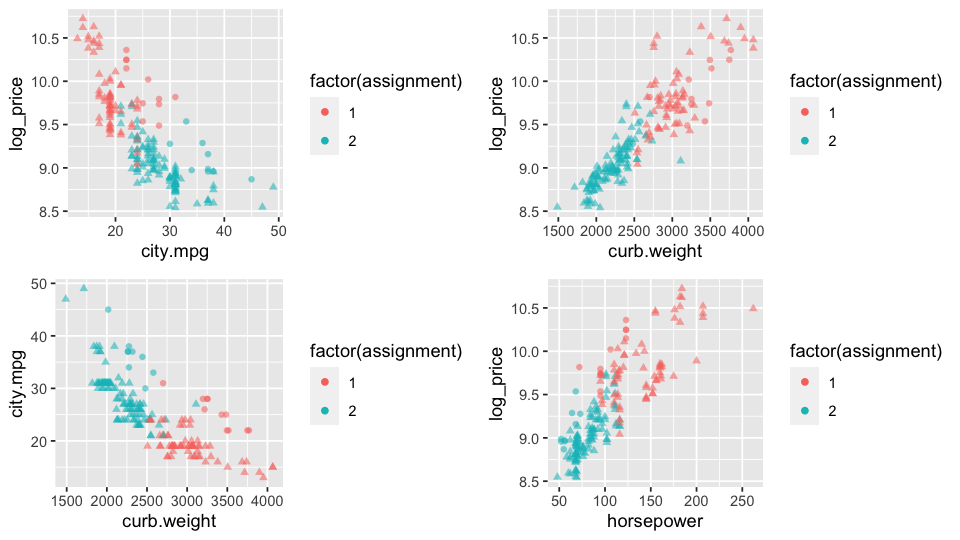

In [17]:
plot_auto_cluster = function(auto_dummies){
    options(repr.plot.width=8, repr.plot.height=4.5)
    grid.arrange(ggplot(auto_dummies, aes_string('city.mpg','log_price')) +
                    geom_point(aes(color = factor(assignment), shape = factor(fuel.type), alpha = 0.2)) +
                    scale_shape(guide = FALSE) + scale_alpha(guide = FALSE),
                 ggplot(auto_dummies, aes_string('curb.weight','log_price')) +
                    geom_point(aes(color = factor(assignment), shape = factor(fuel.type), alpha = 0.2)) +
                    scale_shape(guide = FALSE) + scale_alpha(guide = FALSE),
                 ggplot(auto_dummies, aes_string('curb.weight','city.mpg')) +
                    geom_point(aes(color = factor(assignment), shape = factor(fuel.type), alpha = 0.2)) +
                    scale_shape(guide = FALSE) + scale_alpha(guide = FALSE),
                 ggplot(auto_dummies, aes_string('horsepower','log_price')) +
                    geom_point(aes(color = factor(assignment), shape = factor(fuel.type), alpha = 0.2)) +
                    scale_shape(guide = FALSE) + scale_alpha(guide = FALSE),
                 ncol = 2)
}

plot_auto_cluster(auto_prices)

The K=2 clustering model has seperated the data between high price, low fuel efficiency, high weight and high horsepower autos and ones that have the different characteristics.

Now run the below given code to compute and visualize the cluster assignments for the K=3 model.

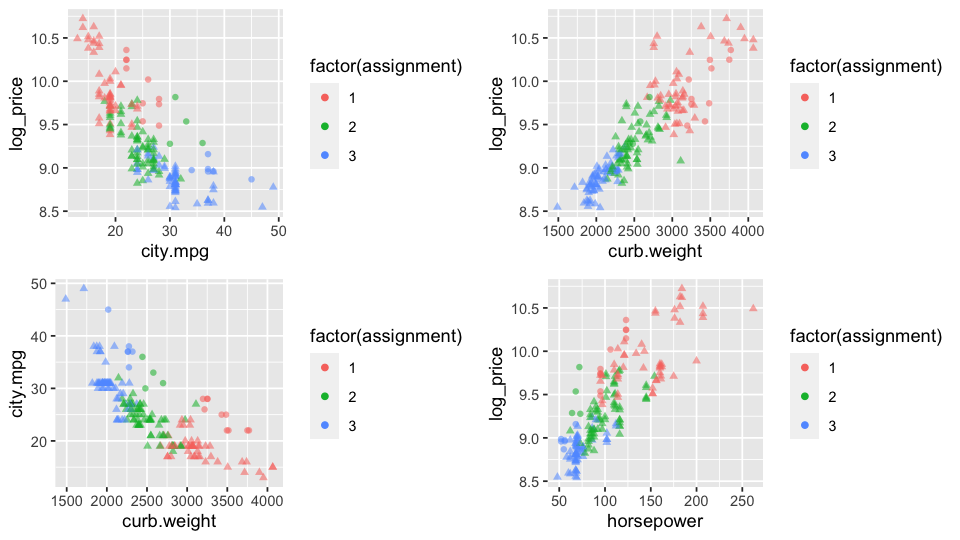

In [18]:
set.seed(4665)
kmeans_3 = kmeans(auto_dummies, centers =3)
auto_prices[,'assignment'] = kmeans_3$cluster
plot_auto_cluster(auto_prices)

The basic separation of the dataset between the clusters is same as the K=2 case. Diesel autos are shown with circular markers and are maily separated into a cluster.

Next, you will compute and visualize the cluster asignments for the K=4 model.

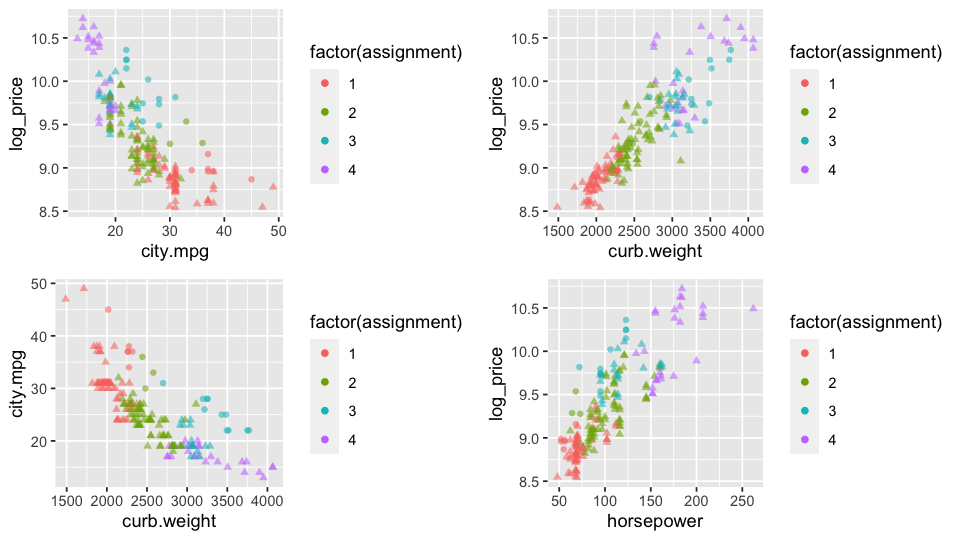

In [20]:
set.seed(475)
kmeans_4 = kmeans(auto_dummies, centers =4)
auto_prices[,'assignment'] = kmeans_4$cluster
plot_auto_cluster(auto_prices)

The clusters in this model shown a bit more overlapping, revealing some interesting underlying patterns. The primary divisions are based on factors such as price, weight, fuel efficiency, horsepower, and fuel type. Notably, all diesel autos are present in two clusters, with one group characterized by high cost, weight, and horsepower, and the other exhibiting lower values in these aspects.

Next, you will compute and visualize the cluster asignments for the K=5 model.

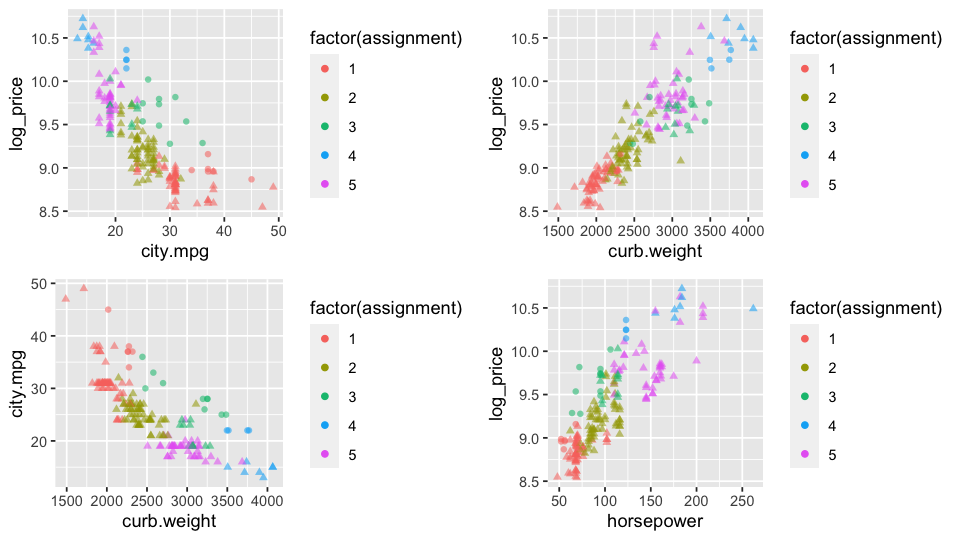

In [21]:
set.seed(475)
kmeans_5 = kmeans(auto_dummies, centers = 5)
auto_prices[,'assignment'] = kmeans_5$cluster
plot_auto_cluster(auto_prices)

The structure of these clusters is notably complex. While it shares a similar pattern with the K=4 model, there are finer divisions among the cases, leading to more overlap between the clusters.

Finally, run the code to compute and visualize the class assignments for the K=6 model.

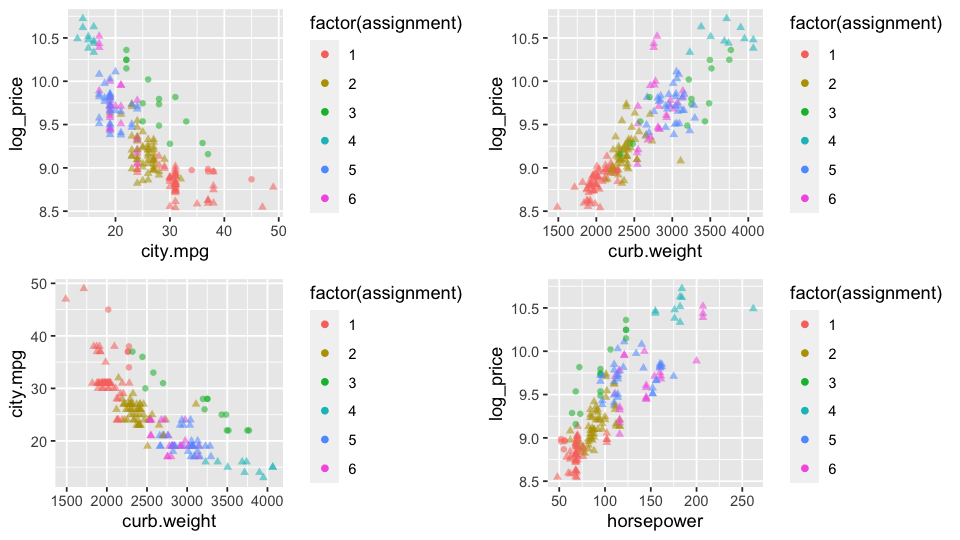

In [22]:
set.seed(475)
kmeans_6 = kmeans(auto_dummies, centers =6)
auto_prices[,'assignment'] = kmeans_6$cluster
plot_auto_cluster(auto_prices)

There is similarity in the structure of these clusters as K=4 and K=5 models.The slight difference is a finer grained divisions between the clusters and yet more overlapping.

Although these visualizations are interseting, selecting the best model based on this evidence is challenging. To establish a more quantitative basis for model selection, we will now calculate and compare the within-cluster sum of squares (WCSS), between-cluster sum of squares (BCSS), and silhouette coefficient (SC) metrics. 

Run the given code below to examine the results.

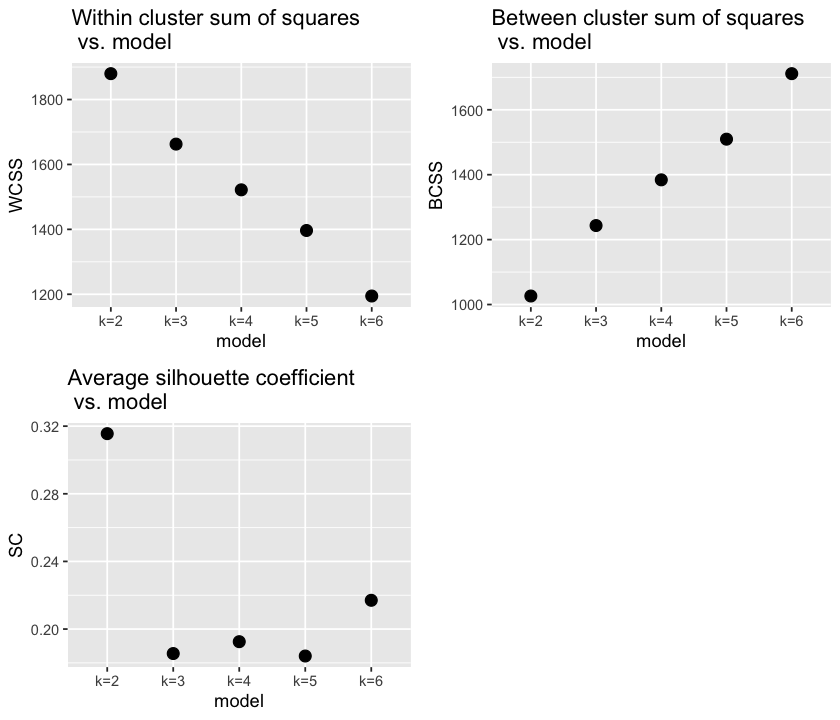

In [25]:
dist_mat <- dist(auto_dummies)

plot_clust_metrics <- function(kmeans_2, kmeans_3, kmeans_4, kmeans_5, kmeans_6) {
    options(repr.plot.width = 7, repr.plot.height = 6) # Set the plot area dimensions
    
    ## Create a data frame with the sum of the WCSS and BCSS and approximate ave SC as columns
    kmeans_metrics <- data.frame(model = c('k=2', 'k=3', 'k=4', 'k=5', 'k=6'), 
                            WCSS = c(sum(kmeans_2$withinss), sum(kmeans_3$withinss), sum(kmeans_4$withinss),
                                      sum(kmeans_5$withinss), sum(kmeans_6$withinss)),
                            BCSS = c(sum(kmeans_2$betweenss), sum(kmeans_3$betweenss), sum(kmeans_4$betweenss),
                                      sum(kmeans_5$betweenss), sum(kmeans_6$betweenss)),
                            SC = c(mean(silhouette(kmeans_2$cluster, dist_mat)[,3]),
                                   mean(silhouette(kmeans_3$cluster, dist_mat)[,3]),
                                   mean(silhouette(kmeans_4$cluster, dist_mat)[,3]),
                                   mean(silhouette(kmeans_5$cluster, dist_mat)[,3]),
                                   mean(silhouette(kmeans_6$cluster, dist_mat)[,3])))
    ## Create side by side plots of WCSS and BCSS vs. the model
    p_wcss <- ggplot(kmeans_metrics, aes(model, WCSS)) + geom_point(size = 3) +
                ggtitle('Within cluster sum of squares \n vs. model')
    p_bcss <- ggplot(kmeans_metrics, aes(model, BCSS)) + geom_point(size = 3) +
                ggtitle('Between cluster sum of squares \n vs. model')
    p_sc <- ggplot(kmeans_metrics, aes(model, SC)) + geom_point(size = 3) +
                ggtitle('Average silhouette coefficient \n vs. model')
    grid.arrange(p_wcss, p_bcss, p_sc, ncol = 2)
}

plot_clust_metrics(kmeans_2, kmeans_3, kmeans_4, kmeans_5, kmeans_6)

BCSS increases and WCSS decreases with increase in numbers of clusters. The range of BCSS and WCSS values is relatively narrow. However, the SC is highest for the k=2 and k=3 models as comapred to other models. All these SC values are low. Overall, it can be assumed that the k=3 model might be the best overall compromise among these models.

## Applying Agglomerative Clustering

After trying the K-means clustering mode with various numbers of clusters, you will now try agglomerative clustering model and will also compare these models using both visualization and the SC metric.

The code given below computes a 2 cluster agglomerative model and visualize the cluster assignments. Run this code.

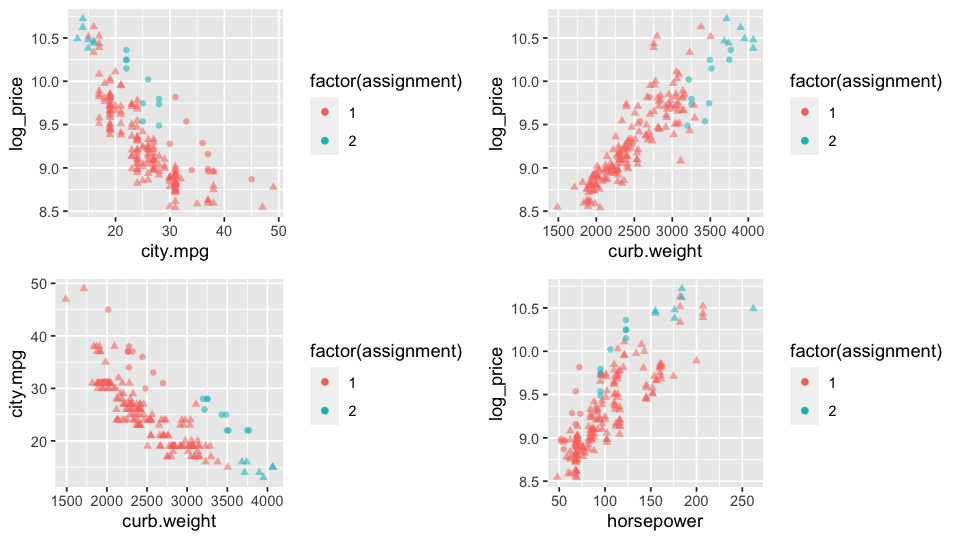

In [26]:
set.seed(7799)
a_clusts = hclust(dist_mat, method = 'average')
agglomerative_2 = cutree(a_clusts, k = 2)
auto_prices[,'assignment'] = agglomerative_2
plot_auto_cluster(auto_prices)

Check the above plots and compare them with the K=2 K-means model of cluster assignment. K-means model shown an approximately even split of the dataset, whereas the agglomerative clustering model has placed the majority of points in one cluster only.

Now, run the code given below to compute and visualize the assignments for the 3 cluster agglomerative model.

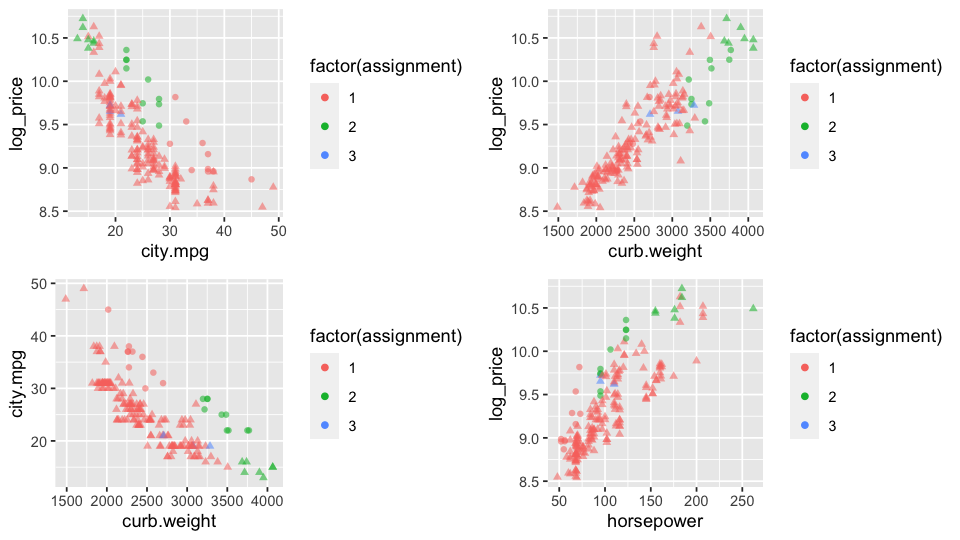

In [27]:
agglomerative_3 = cutree(a_clusts, k = 3)
auto_prices[,'assignment'] = agglomerative_3
plot_auto_cluster(auto_prices)

Check these plots and compare them with the 2 cluster model. It shows that the 3 cluster model has split the larger cluster, but with considerable overlapping in views.

Run the code given below to compute and visualize the assignments for the 4 cluster agglomerative model.

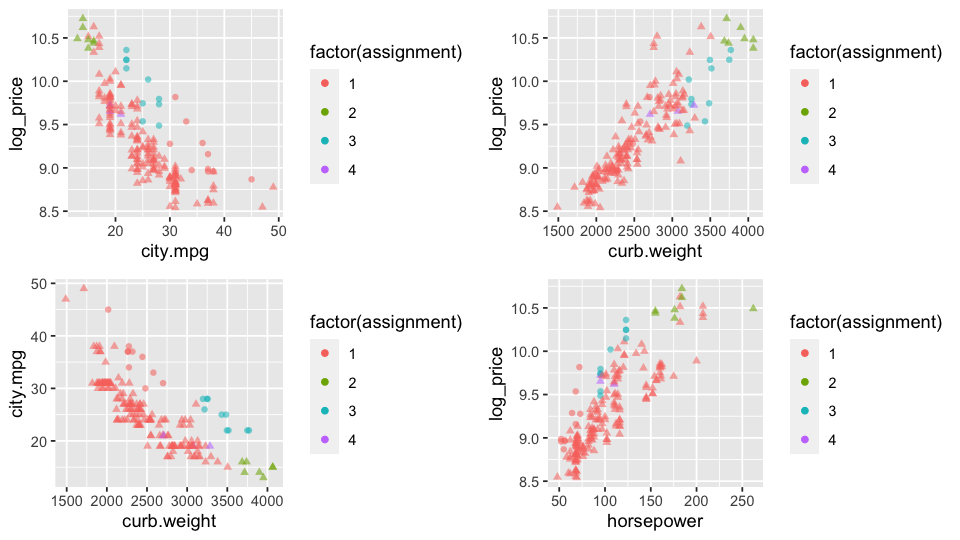

In [28]:
agglomerative_4 = cutree(a_clusts, k = 4)
auto_prices[,'assignment'] = agglomerative_4
plot_auto_cluster(auto_prices)

After comparing these cluster assignments to the 3-cluster model, it becomes evident that low weight, low horsepower, and low-cost autos have been divided into two distinct clusters.

Run the code given below to compute and visualize the assignments for the 5 cluster agglomerative model.

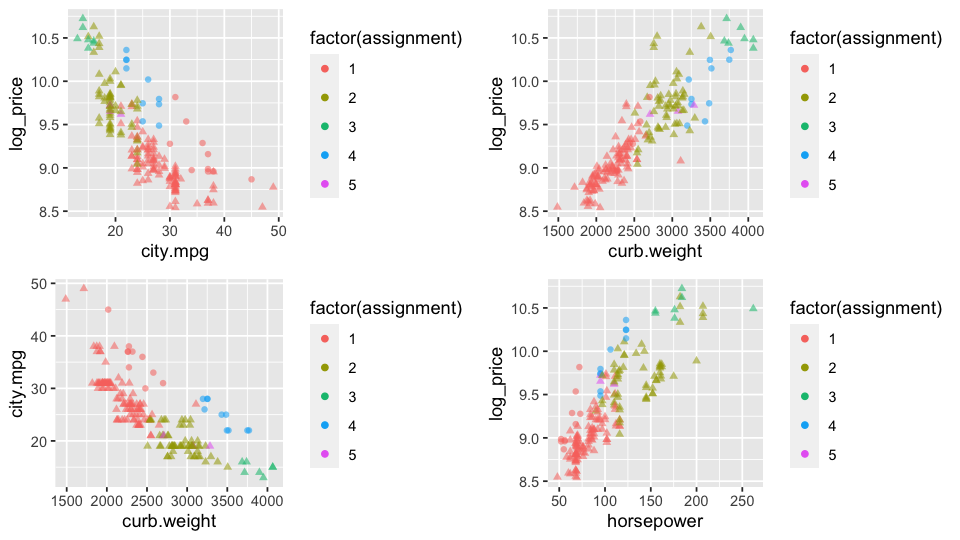

In [30]:
agglomerative_5 = cutree(a_clusts, k = 5)
auto_prices[,'assignment'] = agglomerative_5
plot_auto_cluster(auto_prices)

The data cases are now divided into five distinct groups, and there is minimal overlapping between them. To understand how the clusters divide these cases, you can compare each of the four views provided above.

Run the code given below to compute and visualize the assignments for the 6 cluster agglomerative model.

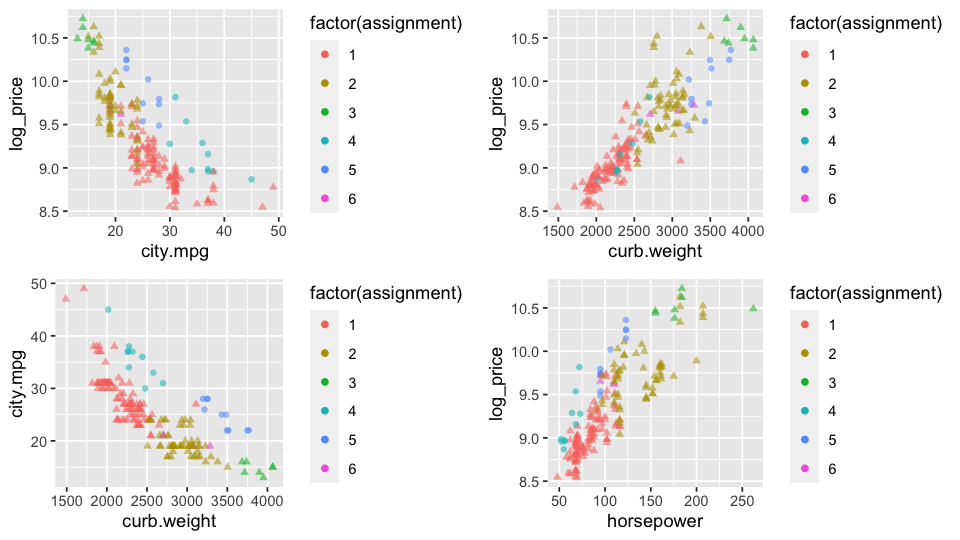

In [31]:
agglomerative_6 = cutree(a_clusts, k = 6)
auto_prices[,'assignment'] = agglomerative_6
plot_auto_cluster(auto_prices)

The outcomes seem to be similar to that of the 5-cluster model. As expected, there is a slightly more detailed separation of some cases.

Lastly, run the code in the cell below to calculate and present the silhouette coefficient (SC) for the agglomerative clustering models.

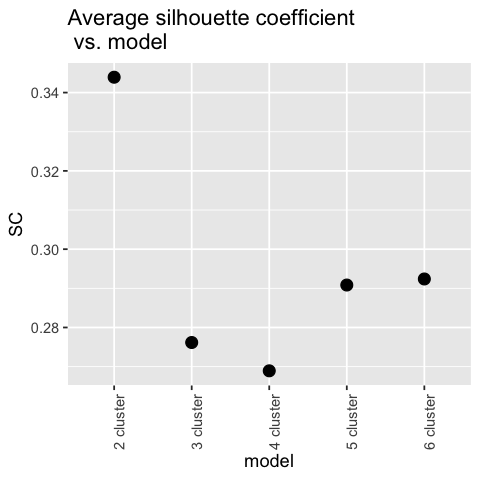

In [32]:
options(repr.plot.width=4, repr.plot.height=4) # Set the plot area dimensions

SC_metrics = data.frame(model = c('2 cluster', '3 cluster', '4 cluster',
                                 '5 cluster', '6 cluster'),
                        SC = c(mean(silhouette(agglomerative_2, dist_mat)[,3]),
                                mean(silhouette(agglomerative_3, dist_mat)[,3]),
                                mean(silhouette(agglomerative_4, dist_mat)[,3]),
                                mean(silhouette(agglomerative_5, dist_mat)[,3]),
                                mean(silhouette(agglomerative_6, dist_mat)[,3])))

ggplot(SC_metrics, aes(model, SC)) + geom_point(size = 3) +
                ggtitle('Average silhouette coefficient \n vs. model') +
                theme(axis.text.x = element_text(angle = 90, hjust = 1))

The SC values are closely clustered within a narrow range. The 2-cluster model has the highest SC value. However, the 5 and 6-cluster models also demonstrate well-defined divisions of the cases and have reasonable SC values. Hence, these models are considered preferable choices.

## Summary

In this lab, you have performed computations, evaluations, and comparisons of K-means and agglomerative clustering models with 2, 3, 4, 5, and 6 clusters applied to the automotive dataset. As is typical with unsupervised learning, comparing models and identifying the most interesting aspects of data structure from clustering can be challenging.

The analysis revealed the following insights:

1. The k=3 model seems to strike a good balance between the metrics among the k-means models.

2. The agglomerative models with 5 or 6 clusters appear to be the best among those tested. Although they revealed interesting structure, the SC values were relatively low.

To further explore the automotive data's cluster analysis, you can consider the following extensions:

1. Experiment with larger numbers of clusters to determine if finer groupings reveal additional underlying structure.

2. For agglomerative clustering, try using different linkage functions and distance metrics to observe how they impact the results.